# Compute empirical distribution instead of training in few-data case

No training; Use empirical distribution to replace score function;

1. Load 1 image;
2. Compute empirical distribution, at time t;
3. Loop from T to 0 to generate;


Terminology:

+ Red font or box means questionble parts.
+ N1M1 dataset, "N-sample-M-dim dataset", 
  - One image (128x128x3): N1M(128x128x3) $\approx$ N1M50k;
  - 1000 floats: N(1000)M1 = N10kM1;
+ ETM, "Experimental Theory Mismatch"

We denote:
- the forward process as $X(t)$, begin at $X(0)=X_0$ and end at $X(1)$; 
- the backward process as $\bar{X}(s)$, begin at $\bar{X}(0)$ and end at $\bar{X}(1)$
  
1. introduce Brownian motion, 
   - $dX(t)=dW(t)$
   - the simplest model:
   - A gaussian process, the $p(x,x',t')$ is explicit.
   - Forward/backward SDE is known.
   - ONLY backward SDE matters since we compute the score function by empirical distribution of dataset;
   - Case N10kM1 dataset, sampling algorithm;
   - Case N1M(128x128x3) dataset, sampling algorithm;
   - [$\color{red}{\text{ETM}}$]Though the forward-end $X(1)$ is $N(X_0,I)$, but the bacward-begin $\bar{X}(0)$ works in practice and converge to exact $X_0$ with increasing $S$(number of steps).
   - [*Later*]Case 2img and kimg-dataset, sampling algorithm;

2. Another gaussian process, with $X(1)=\mathcal{N}(0,I)$.
   - $dX(t) = \alpha X(t)dt + \beta dW(t)$
   - Find the reverse SDE following the derivation of Brownian motion;

3. Geometry Brownian motion,
   - $dX(t) = \alpha X(t)dt + \beta X(t)dW(t)$

## Introduction

In [1]:
import numpy as np
from pathlib import Path
from MyDDPM.apps.rennet import call_by_inspect
import MyDDPM
img_size = 128  # 如果只想快速实验，可以改为64
p_save = Path(Path(MyDDPM.__file__).parent.parent,"Results")

logdir = Path(p_save,"ddpm2_emp_sample")
logdir.mkdir(parents=True,exist_ok=True)
logdir = logdir.as_posix()

# 超参数选择
T = 100000
alpha = np.sqrt(1 - 0.02 * np.arange(1, T + 1) / T)
beta = np.sqrt(1 - alpha**2)
bar_alpha = np.cumprod(alpha)
bar_beta = np.sqrt(1 - bar_alpha**2)
sigma = beta.copy()

config = dict(locals())

In [2]:
from MyDDPM.apps.ddpm2 import get_imgs

imgs = get_imgs(["CelebAHQ256_1"])
print("- imgs: ")
print(len(imgs))
print(imgs[0])

- imgs: 
64
/home/yumeng/workspace/DDPM-SuJL/Datasets/CelebAHQ_1/00001 (8).jpg


- x0
-- shape: (128, 128, 3)
-- min,max: -1.0 0.94509804
-- mean,std: -0.13055842 0.5814528


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


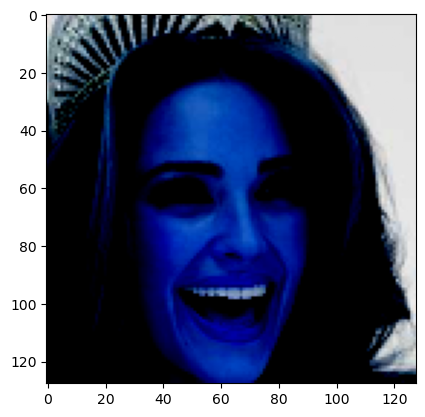

In [3]:
from MyDDPM.apps.ddpm2_h import imread
from matplotlib import pyplot as plt
x0 = imread(imgs[0],img_size)

print("- x0")
print("-- shape:",x0.shape)
print("-- min,max:",x0.min(),x0.max())
print("-- mean,std:",x0.mean(),x0.std())
plt.imshow(x0)
plt.show()

## Brownian motion SDE 
> 1img
> Initial value not 0.

For $t \in [0,1]$,
$$
dX(t) = dW(t),\\
X(0)=X_0
$$


Notice we have :
- time $t \in [0,1]$, $X(1)$ is $\mathcal{N}(X(0),I)$ instead of $\mathcal{N}(0,I)$ (like DDPM), in the forward process;
- time $s \in [0,1]$ in backward process, start from $s=0$.
- $X_0=$ image, range $[-1,1]$ of shape $(\text{batch\_size}, H,W,3)$



Assume noise on each pixel are iid Gaussian,


**The SDE**:

$$
\begin{align}
\left\{ \begin{aligned}
dX(t) = dW(t),\\
X(0) = X_0\\

\end{aligned}\right.
\end{align}
$$

Notice:
- $X(t) \sim \mathcal{N}(X_0,tI)$, then
- $X(1) \sim \mathcal{N}(X_0,I)$.

Later we will derive a version of $X(1) \sim \mathcal(0,I)$, which is'ore close to original DDPM. Since we compute score function based on Data, so sampling start from a dist related to data is OK.


**Transition (here refer to the conditional distribution)**:

Load an image as HWC, (C=3). Use $x^i(k)$ for k-th pixel of i-th image in dataset; $\pi_0$ is the probabilty measure of all-data. Here we replace it with empirical distribution of N-sample dataset, that is, each sample have same weight.

$$
\begin{align}
\begin{aligned}
    p(x,t) &= \int_\mathbb{R} p(x,t|x',0) \pi_0(dx')\\
           &= \frac{1}{N} \sum_{i=1}^{N} p(x,t|x^i,0)
\end{aligned}
\end{align}
$$

$$
p(x,t|x',t') = \frac{1}{\sqrt{2 \pi (t-t')}}\exp\left(\frac{(x-x')^2}{-2(t-t')}\right),~ t>t'
$$ 
i.e.,
$$
x = x' + \sqrt{t-t'}\varepsilon,~ \varepsilon \sim\mathcal{N}(0,1)
$$

then $X(1) \sim p(x,1)$.

Case $N=1$, ${x^i}_{i=0}^{N}={x^0}$,i.e., $x'=x^0$, $t'=0$ and $p(x^0,0)=1$.
$$
\begin{align}
p(x,t)= 1*p(x,t|x^0,0) = \frac{1}{\sqrt{2 \pi t}}\exp\left(\frac{(x-x^0)^2}{-2t}\right)\\

\end{align}
$$


### Wrong but work
- `sample_1`, `run_1`
- start from N(0,1) instead of p(x,1)
- 1img case;


The reverse SDE, $s \in [0,1]$:

$$
\begin{align}
\left\{
    \begin{aligned}
    d\bar{X}(s) = \frac{\partial}{\partial x} \log p(\bar{X}(s), 1-s)dt + d\bar{W}(s)\\
    \bar{X}(0) \sim  = \mathcal{N}(0,I) \neq\colorbox{red}{  p(x,1)},\\
\end{aligned}\right.
\end{align}
$$

where

$$
\frac{\partial}{\partial x} \log p(x,t) = \frac{(x-x^0)}{-t}
$$

The sampling, for $s=0,1/S,2/S,\cdots,(S-1)/S$:

$$
\begin{align}
\left\{ \begin{aligned}
    \bar{x}(s+1/S) :=\bar{x}(s) -\frac{x(s)-x^0}{1-s} + \sqrt{1-s} \bar{\varepsilon}(s),~ \bar{\varepsilon}(s) \sim \mathcal{N}(0,I)\\
    \bar{x}(0) \sim \mathcal{N}(0,I)
\end{aligned} \right.
\end{align}
$$

then $\bar{x}_S \approx \bar{x}(1)$ is a new image;  

<div style="border: 2px solid black; padding: 10px; font-weight: bold;">
    <font color="red">#BUG #FIXME #NOTICE #TODO</font>

    In the following script we start sampling with N(0,I) which is not corresponding p(x,1)=N(x^0,I).

    Though the script works well and converge by increasing T ... ...
    
    BUT IT IS theorictially WRONG. BUT WHY?? 
</div>




100% 2000/2000 [00:06<00:00, 317.97it/s]


- T= 2000
- y0 min/max:  -1.0 0.9902109277629141
- mse:  0.0004963410674345215
Human friendly (RGB)


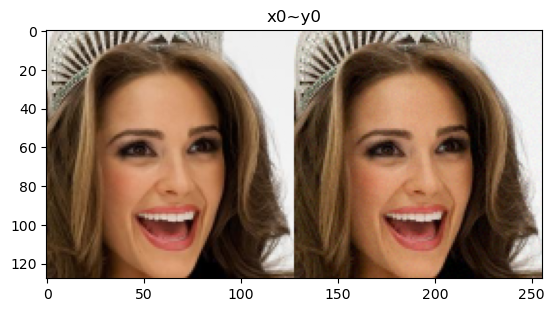

In [4]:
from tqdm import tqdm
def sample_1(x0,T,n):
    
    y_states = []
    y = np.random.randn(n, img_size, img_size, 3) # xT
    x0 = x0[np.newaxis,:]
    t_old = 0/T
    for i in tqdm(range(T), ncols=0):
        t = (i+1)/T # (1,...,T)/T
        # score_func_1
        sf=  -(y-x0)/(1-t_old)
        y += sf *(t-t_old) + np.sqrt(t-t_old)* np.random.randn(*y.shape)
        y_states.append(y)
        t_old = t
    
    return y_states

from matplotlib import pyplot as plt
import cv2

def run_1(x0, T, n, n_show,*,nodisp=False):
    assert n_show<=n
    y_states = sample_1(x0, T=T , n=n)

    y0 = y_states[-1]
    y0 = np.clip(y0, -1, 1)
    print("- T=",T)
    print("- y0 min/max: ", y0.min(), y0.max())
    err = np.sum((y0-x0)**2)/y0.size
    print("- mse: ", err)
    
    if n_show>0:
        rows = []
        for i in range(n_show):
            # plt.figure()
            # plt.title("BGR(cv2 default)")
            # plt.imshow(y0[i])
            # plt.show()
            row = np.concatenate([
            cv2.cvtColor((x0+1)/2, cv2.COLOR_BGR2RGB),
            cv2.cvtColor((y0[i].astype("float32")+1)/2, cv2.COLOR_BGR2RGB)
            ],axis=1)
            rows.append(row)
        figure = np.concatenate(rows,axis=0)

    
        from matplotlib import pyplot as plt
        print("Human friendly (RGB)")
        plt.figure()
        plt.title("x0~y0")
        plt.imshow(figure)
        if not nodisp:
            plt.show()
        else:
            plt.close()

    return y_states, err

_ = run_1(x0,T=2000,n=2,n_show=1)


With increasing $S$, we measure the average-L2 loss between $x^0$ and $\bar{x}^0$.

In [5]:
if False: # skip for speed. Code is correct
    count = 20
    step = 100
    T_l =[(j+1)*step for j in range(count)]
    err_l = []
    for j,T in enumerate(T_l):
        _,err = run_1(x0,T=T,n=8,n_show=0)
        err_l.append(err)

    plt.figure()
    plt.plot(T_l, err_l)
    plt.xlabel("$S$")
    plt.ylabel("avg $L^2$")
    plt.show()


### Corrected
- 1img
- Use p(x,1) 


Next, We try to start from $\bar{X}(s=0):=p(x,1)=N(x^0,I)$ instead of $N(0,I)$. 

100% 2000/2000 [00:06<00:00, 322.14it/s]


- T= 2000
- y0 min/max:  -1.0 0.9934064181046047
- mse:  0.0004963507677113155
Human friendly (RGB)


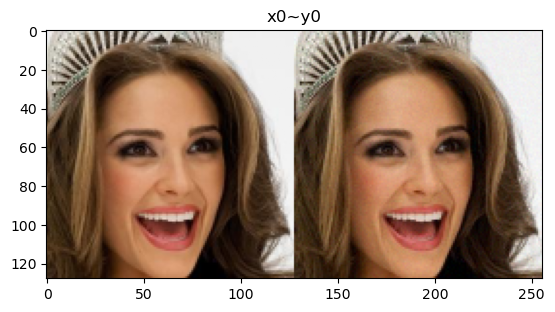

In [6]:
from tqdm import tqdm


def score_function_2(t,x,x0):
    return -(x-x0)/(t)

def sample_2(x0,T,n):
    
    y_states = []
    y = np.random.randn(n, img_size, img_size, 3) + x0 # xT
    x0 = x0[np.newaxis,:]
    t_old = 0/T
    for i in tqdm(range(T), ncols=0):
        t = (i+1)/T # (1,...,T)/T
        # score_func_1
        sf=  score_function_2((1-t_old),y,x0)
        y += sf *(t-t_old) + np.sqrt(t-t_old)* np.random.randn(*y.shape)
        y_states.append(y)
        t_old = t
    
    return y_states


from matplotlib import pyplot as plt
import cv2

def run_2(x0, T, n, n_show,*,nodisp=False):
    assert n_show<=n
    y_states = sample_2(x0, T=T , n=n)

    y0 = y_states[-1]
    y0 = np.clip(y0, -1, 1)
    print("- T=",T)
    print("- y0 min/max: ", y0.min(), y0.max())
    err = np.sum((y0-x0)**2)/y0.size
    print("- mse: ", err)
    
    if n_show>0:
        rows = []
        for i in range(n_show):
            # plt.figure()
            # plt.title("BGR(cv2 default)")
            # plt.imshow(y0[i])
            # plt.show()
            row = np.concatenate([
            cv2.cvtColor((x0+1)/2, cv2.COLOR_BGR2RGB),
            cv2.cvtColor((y0[i].astype("float32")+1)/2, cv2.COLOR_BGR2RGB)
            ],axis=1)
            rows.append(row)
        figure = np.concatenate(rows,axis=0)

    
        from matplotlib import pyplot as plt
        print("Human friendly (RGB)")
        plt.figure()
        plt.title("x0~y0")
        plt.imshow(figure)
        if not nodisp:
            plt.show()
        else:
            plt.close()

    return y_states, err


_ = run_2(x0,T=2000,n=2,n_show=1)


### 3. kimg case; Wrong start for reverse
- start from N(0,1)

In [7]:
from MyDDPM.apps.ddpm2 import get_imgs

imgs = get_imgs(["CelebAHQ256"])
print("- imgs: ")
print(len(imgs))
print(imgs[0])

- imgs: 
30000
/home/yumeng/workspace/DDPM-SuJL/Datasets/CelebAHQ/data256x256/00342.jpg


12254 0.0
12254


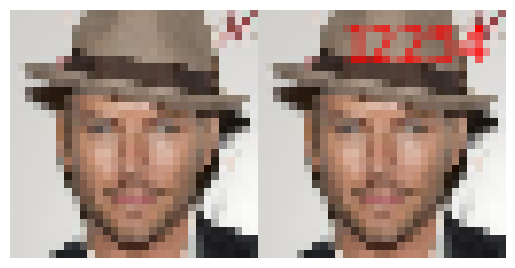

In [8]:
def make_data_3(imgs, N, img_size):
    data = np.array([imread(imgs[i],img_size) for i in range(N)])
    ids=  [Path(img_path).stem for img_path in imgs]
    def get_id_by_order(i):
        """i-th data"""
        return ids[i]
    def get_id_by_value(value,start,end=None,eps=1/255/2):

        for order in range(start,end):
            d= data[order]
            err = np.sum((np.array(value)-d)**2)/d.size # aver-l2
            if err<eps:
                id = get_id_by_order(order)
                break
        else:
            id = None
        return id, err , order
    
    return data, get_id_by_order, get_id_by_value

def mark_image_with_id(target, *, as_img, match, except_no_matched=False):
    """
    target: same with data[k], k in 0,...,N-1
    match(target) --> id, error

    Return: HW3, float [0,1]
    """
    id,err,order = match(target)
    img = as_img(target)

    if except_no_matched:
        assert id is not None, f"e={err}"
    else:
        
        if id is None:
            id = -1
    import matplotlib.pyplot as plt
    dpi = 150
    fig = plt.figure(figsize = (img.shape[1]/dpi, img.shape[0]/dpi), dpi=dpi) #figure with correct aspect ratio
    ax = plt.axes((0,0,1,1)) #axes over whole figure
    ax.axis('off')
    ax.imshow(img,extent=[0, img.shape[0], img.shape[1], 0])
    text = f"{id}"

    img_width = img.shape[1]
    font_size = round(12*img_width/128)
    font = {'size': font_size}
    # Draw text on the image
    ax.text(10, font_size/dpi*(350+20), text, fontdict=font, color='red') # 
    # f.savefig('Invitation00001.png',dpi=300)

    # Get figure as numpy array
    canvas = fig.canvas
    canvas.draw()
    img_with_text = np.array(canvas.renderer.buffer_rgba()) # [0,255], HW4
    img_with_text = img_with_text[:,:,:3]/255
    plt.close()

    return img_with_text

def _test():
    N_used = 8
    data, get_id_by_order, get_id_by_value = make_data_3(imgs,N_used,img_size=32)
    order = 4
    assert order< N_used
    v = data[order]
    id_real =  get_id_by_order(order)
    id,err,ord = get_id_by_value(v,0,8)
    print(id,err)
    print(id_real)

    as_img = lambda v: cv2.cvtColor((v+1)/2, cv2.COLOR_BGR2RGB) 
    img = as_img(v)
    img_t = mark_image_with_id(v, as_img = as_img , match = lambda target:get_id_by_value(target, 0, N_used, eps = 1/255/2) )
    plt.figure()
    plt.imshow(np.concatenate([img,img_t],axis=1))
    plt.axis("off")
    plt.show()
    plt.close()

_test()


100% 600/600 [00:02<00:00, 299.52it/s]


- T= 600
- y0.shape
- y0 min/max:  -1.0 1.0
Human friendly (RGB)
- save figure:  /home/yumeng/workspace/DDPM-SuJL/Results/ddpm2_emp_sample/run_3__N4T600n4__data.png


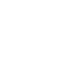

Human friendly (RGB)
- save figure:  /home/yumeng/workspace/DDPM-SuJL/Results/ddpm2_emp_sample/run_3__N4T600n4__data_t.png


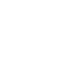

Human friendly (RGB)
- save figure:  /home/yumeng/workspace/DDPM-SuJL/Results/ddpm2_emp_sample/run_3__N4T600n4__samp.png


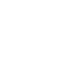

Human friendly (RGB)
- save figure:  /home/yumeng/workspace/DDPM-SuJL/Results/ddpm2_emp_sample/run_3__N4T600n4__samp_t.png


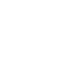

In [9]:

def score_function_3(s, x, data:np.ndarray):
    """data: NHW3
    x:BHW3
    
    
    In fact this is a gradient ascending , score \nabla log p_t(x), for dX = dW(s)
    """
    N = data.shape[0]

    data_ = data[np.newaxis,:,:,:,:] # 1NHW3
    x_ = x[:,np.newaxis,:,:,:] # B1HW3
    # === before 23-11-24
    g = (x_-data_)**2 # BNHW3
    g_ = np.sum(g,axis=-1,keepdims=True)
    g_ = np.sum(g_,axis=-2,keepdims=True)
    h = np.sum(g_,axis=-3,keepdims=True)# BN111
    hmax = np.max(h,axis=1,keepdims=True)# B1111
    v = np.sum( np.exp(h-hmax)*(x_-data_)/(-s), axis=1) # BHW3
    v =  v/np.sum(np.exp(h-hmax),axis=1)
    # ===
    
    if data.shape[0]==1:
        assert np.sum(v - (x-data)/(-s))<1e-6, f"{np.sum(v)},\n{np.sum((x-data)/(-s))}"
    

    return v

from tqdm import tqdm
def sample_3(data,T,n, *, img_size, x0=None):
    
    y_states = []
    if x0 is None:
        x0_ = 0
    else:
        x0_ = x0[np.newaxis,:] # 1HW3
    y = np.random.randn(n, img_size, img_size, 3) + x0_ # xT, BHW3
    t_old = 0/T
    for i in tqdm(range(T), ncols=0):
        t = (i+1)/T # (1,...,T)/T
        # score_func_1
        sf=  score_function_3(1-t_old,y,data) # t_old = 0,1/T,...,(T-1)/T
        #(t-t_old) == (1-t_old) - (1-t)
        
        # === before 23-11-24 
        y += sf *(t-t_old) + np.sqrt(t-t_old)* np.random.randn(*y.shape)
        # ===
       
        y_states.append(y.copy())
        t_old = t
    
    return y_states

from matplotlib import pyplot as plt
import cv2
import math
import numpy as np

def run_3(N, T, n, img_size, x0=None, *, N_show, n_show, nodisp=False,logdir=None):
    """
    Use N samples in data, generate n imgs;
    Show grid of N_show and n_show;
    """
    data, get_id_by_order, get_id_by_value = make_data_3(imgs,N, img_size)
    as_img = lambda v: cv2.cvtColor((v+1)/2, cv2.COLOR_BGR2RGB) 
    assert n_show<=n
    assert N_show<=N
    
    y_states = sample_3(data, T=T , n=n, img_size= img_size, x0=x0)

    y0 = y_states[-1]
    y0 = np.clip(y0, -1, 1)
    print("- T=",T)
    print("- y0.shape")
    print("- y0 min/max: ", y0.min(), y0.max())
    if x0 is not None:
        err = np.sum((y0-x0)**2)/y0.size
        print("- mse: ", err)
    
    
    
    
    if n_show>0:
        def show_n_save(figure,title, func_name="run_3"):    
            from matplotlib import pyplot as plt
            print("Human friendly (RGB)")
            plt.figure(figsize=(round(figure.shape[0]/300),round(figure.shape[1]/300)),dpi=300)
            plt.axis("off")
            plt.imshow(figure)
            if logdir is not None:
                p = Path(logdir,f"{func_name}__N{N}T{T}n{n}__{title}.png")
                plt.imsave(p.as_posix(),figure)
                print(f"- save figure:  {p.as_posix()}")
            if not nodisp:
                plt.show()
            else:
                plt.close()

        def make_grid(get_data_k,N,n_show,*,id_matching="order",eps= 1/255/2):
            """
            get_data_k(k)--> HW3 array,BGR, range[-1,1], float

            id_matching:
            - image:    Loop on k=0,...,N-1, compute error to find the fisrt id for error<eps
            """
            rows = []
            n_grid = math.ceil(math.sqrt(n_show))
            for i in range(n_grid):
                # plt.figure()
                # plt.title("BGR(cv2 default)")
                # plt.imshow(y0[i])
                # plt.show()
                row_ = []
                for j in range(min(n_show-i*n_grid,n_grid)):
                    d = np.array(get_data_k(j+i*n_grid)).astype(np.float32)
                    img= cv2.cvtColor((d+1)/2, cv2.COLOR_BGR2RGB) 
                    img_with_text = mark_image_with_id(d, as_img=as_img, match = lambda target:get_id_by_value(target,0,N,eps))

                    row_.append((img,img_with_text))
                
                rows.append((np.concatenate([v[0] for v in row_],axis=1),np.concatenate([v[1] for v in row_],axis=1)))

            figure = np.concatenate([r[0] for r in rows],axis=0).astype(np.float32)
            figure_t = np.concatenate([r[1] for r in rows],axis=0).astype(np.float32)
            return figure, figure_t

     
        figure_data, figure_data_t = make_grid(lambda k: data[k],N, N_show,id_matching="order")
        show_n_save(figure_data,"data")
        show_n_save(figure_data_t,"data_t")

        figure_data, figure_data_t = make_grid(lambda k: y0[k], N, n_show,id_matching="image",eps=1/255/2)
        show_n_save(figure_data,"samp")
        show_n_save(figure_data_t,"samp_t")

    return y_states

y_states= run_3(N=4,T=600,n=4, img_size=64, N_show=4, n_show=4, logdir=logdir)

100% 400/400 [00:04<00:00, 92.60it/s]

- T= 400
- y0.shape
- y0 min/max:  -1.0 1.0
Human friendly (RGB)
- save figure:  /home/yumeng/workspace/DDPM-SuJL/Results/ddpm2_emp_sample/run_3__N16T400n4__data.png


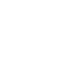

Human friendly (RGB)
- save figure:  /home/yumeng/workspace/DDPM-SuJL/Results/ddpm2_emp_sample/run_3__N16T400n4__data_t.png


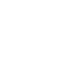

Human friendly (RGB)
- save figure:  /home/yumeng/workspace/DDPM-SuJL/Results/ddpm2_emp_sample/run_3__N16T400n4__samp.png


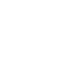

Human friendly (RGB)
- save figure:  /home/yumeng/workspace/DDPM-SuJL/Results/ddpm2_emp_sample/run_3__N16T400n4__samp_t.png


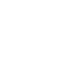

In [10]:
y_states= run_3(N=16,T=400,n=4, img_size=64, N_show=4, n_show=4, logdir=logdir)

In [ ]:
_ = run_3(N=64,T=600,n=25 ,img_size=64,N_show = 25, n_show=25, logdir=logdir)

In [ ]:
_ = run_3(N=64,T=400,n=25 ,img_size=64,N_show = 25, n_show=25, logdir=logdir)

In [ ]:
_ = run_3(N=64,T=200,n=25 ,img_size=64,N_show = 25, n_show=25, logdir=logdir)

In [ ]:
_ = run_3(N=64,T=100,n=25 ,img_size=64,N_show = 25, n_show=25, logdir=logdir)

In [ ]:
_ = run_3(N=64,T=50,n=25 ,img_size=64,N_show = 25, n_show=25, logdir=logdir)

In [ ]:
_ = run_3(N=64,T=25,n=25 ,img_size=64,N_show = 25, n_show=25, logdir=logdir)

100% 600/600 [00:01<00:00, 310.68it/s]


- T= 600
- y0.shape
- y0 min/max:  nan nan
Human friendly (RGB)
- save figure:  /home/yumeng/workspace/DDPM-SuJL/Results/ddpm2_emp_sample/run_3__N4T600n4__data_3new.png


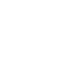

Human friendly (RGB)
- save figure:  /home/yumeng/workspace/DDPM-SuJL/Results/ddpm2_emp_sample/run_3__N4T600n4__data_t_3new.png


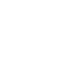

Human friendly (RGB)
- save figure:  /home/yumeng/workspace/DDPM-SuJL/Results/ddpm2_emp_sample/run_3__N4T600n4__samp_3new.png


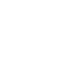

Human friendly (RGB)
- save figure:  /home/yumeng/workspace/DDPM-SuJL/Results/ddpm2_emp_sample/run_3__N4T600n4__samp_t_3new.png


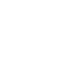

In [11]:

def score_function_3_new(s, x, data:np.ndarray):
    """data: NHW3
    x:BHW3
    
    """
    N = data.shape[0]

    data_ = data[np.newaxis,:,:,:,:] # 1NHW3
    x_ = x[:,np.newaxis,:,:,:] # B1HW3
    # === before 23-11-24
    # g = (x_-data_)**2 # BNHW3
    # g_ = np.sum(g,axis=-1,keepdims=True)
    # g_ = np.sum(g_,axis=-2,keepdims=True)
    # h = np.sum(g_,axis=-3,keepdims=True)# BN111
    # hmax = np.max(h,axis=1,keepdims=True)# B1111
    # v = np.sum( np.exp(h-hmax)*(x_-data_)/(-t), axis=1) # BHW3
    # v =  v/np.sum(np.exp(h-hmax),axis=1)
    # ===
    # === 23-11-24, s==beta_bar_t
    # alpha_bar = 1-s
    delta = x_-np.sqrt(1-s)*data_
    g = (delta)**2 # BNHW3
    g_ = np.sum(g,axis=-1,keepdims=True)
    g_ = np.sum(g_,axis=-2,keepdims=True)
    h = np.sum(g_,axis=-3,keepdims=True)# BN111
    h = -0.5/s*h
    hmax = np.max(h,axis=1,keepdims=True)# B1111
    v = np.sum( np.exp(h-hmax)*delta/(-s), axis=1) # BHW3
    v =  v/np.sum(np.exp(h-hmax),axis=1)
    # ===
    if data.shape[0]==1:
        assert np.sum(v - (x-data)/(-s))<1e-6, f"{np.sum(v)},\n{np.sum((x-data)/(-s))}"
    

    return v

from tqdm import tqdm
def sample_3_new(data,T,n, *, img_size, x0=None):
    
    y_states = []
    if x0 is None:
        x0_ = 0
    else:
        x0_ = x0[np.newaxis,:] # 1HW3
    y = np.random.randn(n, img_size, img_size, 3) + x0_ # xT, BHW3
    t_old = 0/T
    for i in tqdm(range(T), ncols=0):
        t = (i+1)/T # (1,...,T)/T
        # score_func_1
        sf=  score_function_3_new(1-t_old,y,data) # t_old = 0,1/T,...,(T-1)/T
        #(t-t_old) == (1-t_old) - (1-t)
        # === before 23-11-24 
        # #y += sf *(t-t_old) + np.sqrt(t-t_old)* np.random.randn(*y.shape)
        # ===
        # === 23-11-24
        # beta_bar_t === 1-t_old = 1-(i+1)/T, i = 0,1,..,T-1
        # alpha_bar_t = t_old
        # alpha = t_old/t
        # beta = 1- t_old/t=  (t-t_old)/t
        beta = (t-t_old)/(t)
        y = (y + sf *beta)/np.sqrt(1-beta) + np.sqrt(beta)* np.random.randn(*y.shape)
        # ===
        y_states.append(y.copy())
        t_old = t
    
    return y_states

from matplotlib import pyplot as plt
import cv2
import math
import numpy as np

def run_3_new(N, T, n, img_size, x0=None, *, N_show, n_show, nodisp=False,logdir=None):
    """
    Use N samples in data, generate n imgs;
    Show grid of N_show and n_show;
    """
    data, get_id_by_order, get_id_by_value = make_data_3(imgs,N, img_size)
    as_img = lambda v: cv2.cvtColor((v+1)/2, cv2.COLOR_BGR2RGB) 
    assert n_show<=n
    assert N_show<=N
    
    y_states = sample_3_new(data, T=T , n=n, img_size= img_size, x0=x0)

    y0 = y_states[-1]
    y0 = np.clip(y0, -1, 1)
    print("- T=",T)
    print("- y0.shape")
    print("- y0 min/max: ", y0.min(), y0.max())
    if x0 is not None:
        err = np.sum((y0-x0)**2)/y0.size
        print("- mse: ", err)
    
    
    
    
    if n_show>0:
        def show_n_save(figure,title, func_name="run_3"):    
            from matplotlib import pyplot as plt
            print("Human friendly (RGB)")
            plt.figure(figsize=(round(figure.shape[0]/300),round(figure.shape[1]/300)),dpi=300)
            plt.axis("off")
            plt.imshow(figure)
            if logdir is not None:
                p = Path(logdir,f"{func_name}__N{N}T{T}n{n}__{title}_3new.png")
                plt.imsave(p.as_posix(),figure)
                print(f"- save figure:  {p.as_posix()}")
            if not nodisp:
                plt.show()
            else:
                plt.close()

        def make_grid(get_data_k,N,n_show,*,id_matching="order",eps= 1/255/2):
            """
            get_data_k(k)--> HW3 array,BGR, range[-1,1], float

            id_matching:
            - image:    Loop on k=0,...,N-1, compute error to find the fisrt id for error<eps
            """
            rows = []
            n_grid = math.ceil(math.sqrt(n_show))
            for i in range(n_grid):
                # plt.figure()
                # plt.title("BGR(cv2 default)")
                # plt.imshow(y0[i])
                # plt.show()
                row_ = []
                for j in range(min(n_show-i*n_grid,n_grid)):
                    d = np.array(get_data_k(j+i*n_grid)).astype(np.float32)
                    img= cv2.cvtColor((d+1)/2, cv2.COLOR_BGR2RGB) 
                    img_with_text = mark_image_with_id(d, as_img=as_img, match = lambda target:get_id_by_value(target,0,N,eps))

                    row_.append((img,img_with_text))
                
                rows.append((np.concatenate([v[0] for v in row_],axis=1),np.concatenate([v[1] for v in row_],axis=1)))

            figure = np.concatenate([r[0] for r in rows],axis=0).astype(np.float32)
            figure_t = np.concatenate([r[1] for r in rows],axis=0).astype(np.float32)
            return figure, figure_t

     
        figure_data, figure_data_t = make_grid(lambda k: data[k],N, N_show,id_matching="order")
        show_n_save(figure_data,"data")
        show_n_save(figure_data_t,"data_t")

        figure_data, figure_data_t = make_grid(lambda k: y0[k], N, n_show,id_matching="image",eps=1/255/2)
        show_n_save(figure_data,"samp")
        show_n_save(figure_data_t,"samp_t")

    return y_states

y_states = run_3_new(N=4,T=600,n=4, img_size=64, N_show=4, n_show=4, logdir=logdir)

In [13]:

from matplotlib import pyplot as plt
import cv2
import math
import numpy as np

def run_4(N, T, n, img_size, logdir, x0=None):
    """
    Use N samples in data, generate n imgs;
    Show grid of N_show and n_show;
    """
    data, get_id_by_order, get_id_by_value = make_data_3(imgs,N, img_size)
    as_img = lambda v: cv2.cvtColor((v+1)/2, cv2.COLOR_BGR2RGB) 
    y_states = sample_3(data, T=T , n=n, img_size= img_size, x0=x0)
    y0 = y_states[-1]
    y0 = np.clip(y0, -1, 1)
    print("- T=",T)
    print("- y0.shape")
    print("- y0 min/max: ", y0.min(), y0.max())
    if x0 is not None:
        err = np.sum((y0-x0)**2)/y0.size
        print("- mse: ", err)
    
    
    

    def show_n_save(figure,title):    
        from matplotlib import pyplot as plt
        print("Human friendly (RGB)")
        plt.figure(figsize=(round(figure.shape[0]/300),round(figure.shape[1]/300)),dpi=300)
        plt.axis("off")
        plt.imshow(figure)
        p = Path(logdir,f"{title}.png")
        plt.imsave(p.as_posix(),figure)
        plt.close()

    def make_grid(get_data_k,N,n_show,*,id_matching="order",eps= 1/255/2):
        """
        get_data_k(k)--> HW3 array,BGR, range[-1,1], float

        id_matching:
        - image:    Loop on k=0,...,N-1, compute error to find the fisrt id for error<eps
        """
        rows = []
        n_grid = math.ceil(math.sqrt(n_show))
        for i in range(n_grid):
            # plt.figure()
            # plt.title("BGR(cv2 default)")
            # plt.imshow(y0[i])
            # plt.show()
            row_ = []
            for j in range(min(n_show-i*n_grid,n_grid)):
                d = np.array(get_data_k(j+i*n_grid)).astype(np.float32)
                img= cv2.cvtColor((d+1)/2, cv2.COLOR_BGR2RGB) 
                img_with_text = mark_image_with_id(d, as_img=as_img, match = lambda target:get_id_by_value(target,0,N,eps))

                row_.append((img,img_with_text))
            
            rows.append((np.concatenate([v[0] for v in row_],axis=1),np.concatenate([v[1] for v in row_],axis=1)))

        figure = np.concatenate([r[0] for r in rows],axis=0).astype(np.float32)
        figure_t = np.concatenate([r[1] for r in rows],axis=0).astype(np.float32)
        return figure, figure_t

     
        figure_data, figure_data_t = make_grid(lambda k: data[k],N, N_show,id_matching="order")
        show_n_save(figure_data,"data")
        show_n_save(figure_data_t,"data_t")

        figure_data, figure_data_t = make_grid(lambda k: y0[k], N, n_show,id_matching="image",eps=1/255/2)
        show_n_save(figure_data,"samp")
        show_n_save(figure_data_t,"samp_t")

    return y_states


## Geometric Brownian motion SDE 
> 1img
> $\mu=0,\sigma=1$

[Wiki-zh](https://zh.wikipedia.org/wiki/%E5%87%A0%E4%BD%95%E5%B8%83%E6%9C%97%E8%BF%90%E5%8A%A8)
[Wiki-en](https://en.wikipedia.org/wiki/Geometric_Brownian_motion)

$$
\begin{align}
dX(t) &= \mu X(t)dt + \sigma X(t) dW(t), \\
X(0)  &= X_0
\end{align}
$$

where $W(t)$ is Wiener process.

**Basic properties:**

At time t,
$$
\mathbb{E}[X] = X_0e^{\mu t},\\
\mathop{Var}[X]=X_0^2 e^{2\mu t}(e^{\sigma^2 t}-1)
$$

Use $\mu=0,\sigma=1$,

$$
\mathbb{E}[X(t)] = X_0,\\
\mathop{Var}[X(t)] = X_0^2(e^t-1)
$$
and 
$$
\mathop{Var}[X(0)] = 0,\\
\mathop{Var}[X(1)] = X_0^2(e-1)
$$